<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 4</b></u></p>
Привет. Эллина!<br>
Точно сдашь, уверен!!!!<br>
1) Вот ниже формируется таблица у тебя. И в ней есть строки, которые ЛИШНИЕ. Как и писал, у нас ковши наблюдаются, в которых нет целвой, но есть первая температура. А объект моделирования у нас - ковш. И если нет целевой у объекта - надо удалять весь ковш. Сейчас они всё ещё в деле))). Наприм ковш номер 3000 - целевой нет. Значить надо удалить. А он всё равно в таблице остался. Посмотри, пожалуйста. В итоге у нас должно быть не более 2300 строк +-) <br>
Т.е. можно сначала удалить партии в этой табличке, где нет целевой! Потом уже выделять первую и последню температуру. Получится не более 2300 партий. И вот дальше уже работать<br>
БУДУ ЖДАТЬ!

In [ ]:
izmer_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor




from numpy.random import RandomState
from matplotlib import pyplot as plt


## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

In [2]:
electrode = pd.read_csv('/datasets/data_arc_new.csv')

syp_materials_ob = pd.read_csv('/datasets/data_bulk_new.csv')

syp_materials_time = pd.read_csv('/datasets/data_bulk_time_new.csv')

gas = pd.read_csv('/datasets/data_gas_new.csv')

izmer_temp = pd.read_csv('/datasets/data_temp_new.csv')

provol_material_ob = pd.read_csv('/datasets/data_wire_new.csv')

provol_material_time = pd.read_csv('/datasets/data_wire_time_new.csv')

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>Как говорится, данные на базе)

## Исследовательсский анализ

### electrode  данные об электродах;

In [3]:

electrode.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [4]:
electrode.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [5]:
electrode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


-перевести в datetime

-пропусков нет

-повтор key
(еоличество итераций обработки материала)



count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64

<AxesSubplot:>

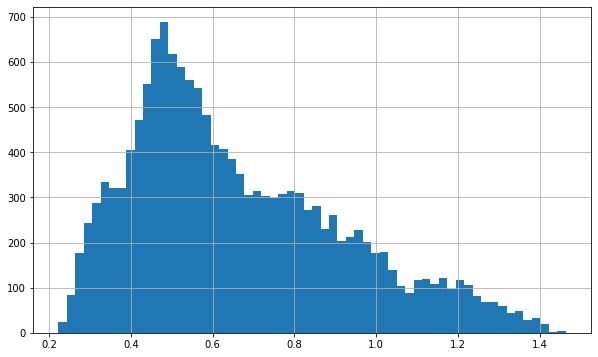

In [6]:
display(electrode['Активная мощность'].describe())
electrode['Активная мощность'].hist(bins=60, figsize=(10,6))

In [7]:
#распределение нормальное, выбросов нет



In [8]:
# приведем тип для работы с датой
electrode['Начало нагрева дугой'] = pd.to_datetime(electrode['Начало нагрева дугой'] )
electrode['Конец нагрева дугой'] = pd.to_datetime(electrode['Конец нагрева дугой'] )
#наверно это буду делать в предобработке

### syp_materials_ob — данные о подаче сыпучих материалов (объём);

In [9]:
display(syp_materials_ob.head())
syp_materials_ob.info()
syp_materials_ob.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<AxesSubplot:>

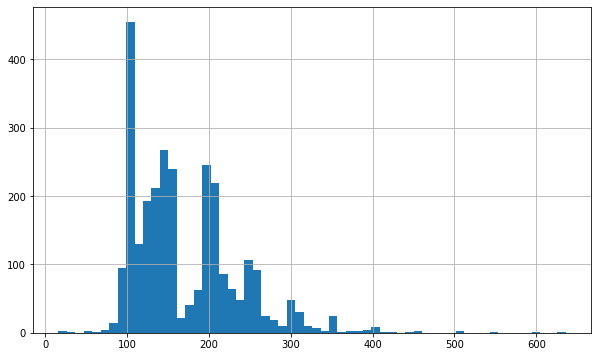

In [10]:
syp_materials_ob['Bulk 14'].hist(bins=60, figsize=(10,6))

-очень много пропусков

-уникальные ключи




### syp_materials_time — данные о подаче сыпучих материалов (время);

In [11]:
display(syp_materials_time.head())
syp_materials_time.info()
syp_materials_time.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


-перевести в datetime

-много пропусков


### gas — данные о продувке сплава газом;

In [12]:
display(gas.head())
gas.info()
gas.describe()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


-пропусков нет

-уникальный ключ

<AxesSubplot:>

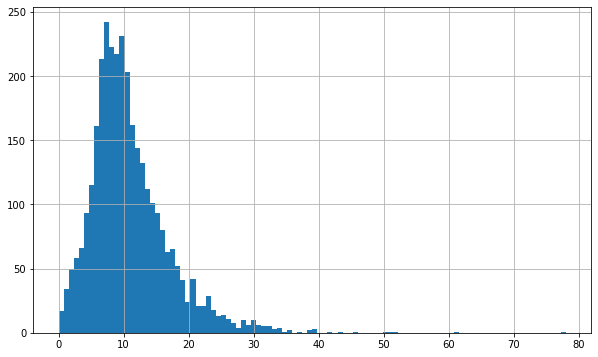

In [13]:
gas['Газ 1'].hist(bins=100, figsize=(10,6))

-есть выбросы после 40

In [14]:
#удалить выброс после 30


### izmer_temp — результаты измерения температуры;

In [15]:
display(izmer_temp.head())
izmer_temp.info()
izmer_temp.describe()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [16]:
izmer_temp['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

-изменить тип datetime

-пропуски в температуре 

-ключ уникальный

<AxesSubplot:>

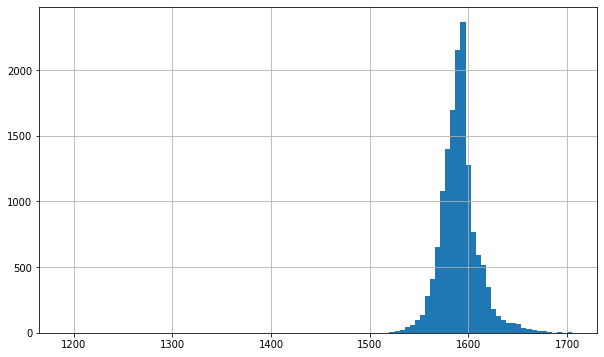

In [17]:
izmer_temp['Температура'].hist(bins=100, figsize=(10,6))

In [18]:
izmer_temp[izmer_temp['Температура'] <= 1500].count()

key             5
Время замера    5
Температура     5
dtype: int64

In [19]:
iz_t = izmer_temp[izmer_temp['Температура'].isna()]
print(izmer_temp)
print(izmer_temp['key'].unique())

        key         Время замера  Температура
0         1  2019-05-03 11:02:04       1571.0
1         1  2019-05-03 11:07:18       1604.0
2         1  2019-05-03 11:11:34       1618.0
3         1  2019-05-03 11:18:04       1601.0
4         1  2019-05-03 11:25:59       1606.0
...     ...                  ...          ...
18087  3241  2019-09-06 16:55:01          NaN
18088  3241  2019-09-06 17:06:38          NaN
18089  3241  2019-09-06 17:21:48          NaN
18090  3241  2019-09-06 17:24:44          NaN
18091  3241  2019-09-06 17:30:05          NaN

[18092 rows x 3 columns]
[   1    2    3 ... 3239 3240 3241]


In [20]:
i = izmer_temp[izmer_temp['key'].isin(izmer_temp['key'].unique())]
print(i.head(30))

    key         Время замера  Температура
0     1  2019-05-03 11:02:04       1571.0
1     1  2019-05-03 11:07:18       1604.0
2     1  2019-05-03 11:11:34       1618.0
3     1  2019-05-03 11:18:04       1601.0
4     1  2019-05-03 11:25:59       1606.0
5     1  2019-05-03 11:30:38       1613.0
6     2  2019-05-03 11:34:04       1581.0
7     2  2019-05-03 11:38:40       1577.0
8     2  2019-05-03 11:46:09       1589.0
9     2  2019-05-03 11:49:38       1604.0
10    2  2019-05-03 11:55:09       1602.0
11    3  2019-05-03 12:06:44       1596.0
12    3  2019-05-03 12:13:42       1597.0
13    3  2019-05-03 12:18:46       1598.0
14    3  2019-05-03 12:25:33       1599.0
15    3  2019-05-03 12:31:04       1600.0
16    3  2019-05-03 12:35:57       1599.0
17    4  2019-05-03 12:39:27       1601.0
18    4  2019-05-03 12:44:37       1623.0
19    4  2019-05-03 12:48:04       1618.0
20    4  2019-05-03 12:53:02       1617.0
21    4  2019-05-03 12:59:47       1625.0
22    5  2019-05-03 13:11:03      

In [21]:
counts = i.groupby('key')['Температура'].count().sort_values(ascending=False)
print(counts)

key
2108    17
1513    16
1689    16
322     14
46      14
        ..
2747     1
2748     1
2749     1
2750     1
3241     1
Name: Температура, Length: 3216, dtype: int64


In [22]:
key_drop = izmer_temp[izmer_temp['Температура'].isna()]['key'].unique()
                      
izmer_temp = izmer_temp.query('key not in @key_drop')  

In [23]:
izmer_temp = izmer_temp.fillna(0)

In [24]:
izmer_temp['Температура']

0        1571.0
1        1604.0
2        1618.0
3        1601.0
4        1606.0
          ...  
13921    1569.0
13922    1604.0
13923    1593.0
13924    1588.0
13925    1603.0
Name: Температура, Length: 13926, dtype: float64

### provol_material_ob — данные о проволочных материалах (объём);

In [25]:
display(provol_material_ob.head())
provol_material_ob.info()
provol_material_ob.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<AxesSubplot:>

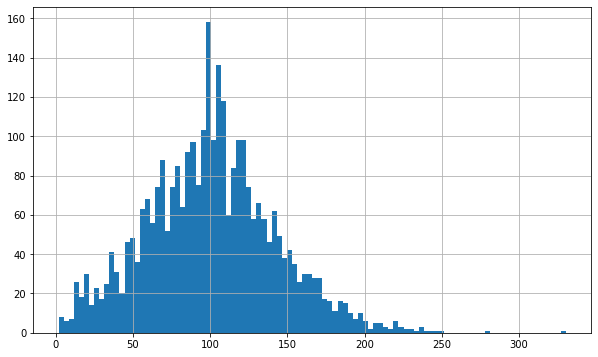

In [26]:
provol_material_ob['Wire 1'].hist(bins=100, figsize=(10,6))

-очень много пропусков

-ключ уникальный

### provol_material_time — данные о проволочных материалах (время).

In [27]:
display(provol_material_time.head())
provol_material_time.info()
provol_material_time.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [28]:

pd.DataFrame(provol_material_time.isna().sum(), columns = ['пропусков']).style.background_gradient()

,пропусков
key,0
Wire 1,26
Wire 2,2002
Wire 3,3018
Wire 4,3067
Wire 5,3080
Wire 6,3008
Wire 7,3070
Wire 8,3062
Wire 9,3052


-оооочень большое количество пропусков

-перевести в datetime

In [29]:
provol_material_time['Wire 1'] = pd.to_datetime(provol_material_time['Wire 1'] )

<AxesSubplot:>

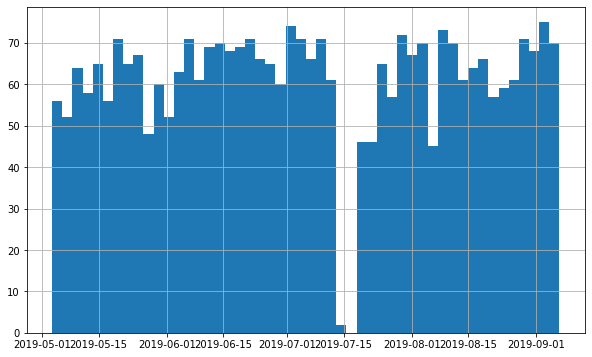

In [30]:
provol_material_time['Wire 1'].hist(bins=50, figsize=(10,6))

In [31]:
provol_material_time['Wire 1'].describe()

/tmp/ipykernel_203/4139899488.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  provol_material_time['Wire 1'].describe()


count                    3055
unique                   3055
top       2019-05-25 04:54:17
freq                        1
first     2019-05-03 11:06:19
last      2019-09-06 17:10:06
Name: Wire 1, dtype: object

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
ОК, Эллина, с первичным анализом - понятно. Есть и аналитика, и локальные выводы!! Это верно.<br>
    
Добавь, пожалуйста: Графический анализ по  присадкам (гистограммы) и общий вывод по разделу, важно знать какое качество данных - что ожидается в предобработке. Буду ждать со следующей итерацией)<br><br>
    
По вопросу ниже: на встрече сегодня обсудили его и некоторые другие. Оставлись ещё вопросы?<br>
БУДУ ЖДАТЬ)

## Общий вывод по исследовательскому анализу

Целевой признак: конечная температура стали ( таблица - izmer_temp)

Будут удалены выбросы в gas 

В присыпках заполнены nanы - 0

Найти полную мощность (удалить 2 других признака?)

Таблица будет объединена по key

После объединения таблиц, при отсутствии целевого признака, удалены все эти значения из общей таблицы

Удалены данные с датой

Посмотреть корреляцию до начала обучения моделей

На этом предобработка данных будет закончена




## Предобработка данных

### Удалим выбросы

In [32]:
#реактивная мощность
electrode[electrode['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [33]:

electrode = electrode[electrode['Реактивная мощность'] > 0]

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 3</b></u></p>
ОК, если это не последня строка по партии - соглашусь. А если последняя - тогда лучше удалять всю партию.

In [34]:
electrode.describe()

,key,Активная мощность,Реактивная мощность
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.662749,0.487115
std,934.593897,0.258894,0.197612
min,1.000000,0.223120,0.153777
25%,806.000000,0.467115,0.337190
50%,1617.000000,0.599578,0.441665
75%,2429.000000,0.830135,0.608223
max,3241.000000,1.463773,1.270284


<AxesSubplot:>

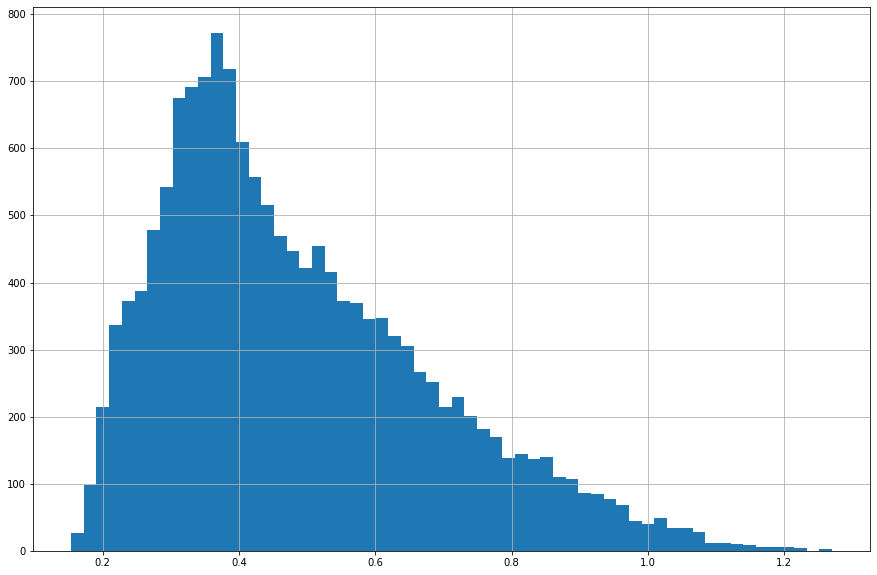

In [35]:
electrode['Реактивная мощность'].hist(bins=60, figsize=(15,10))

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


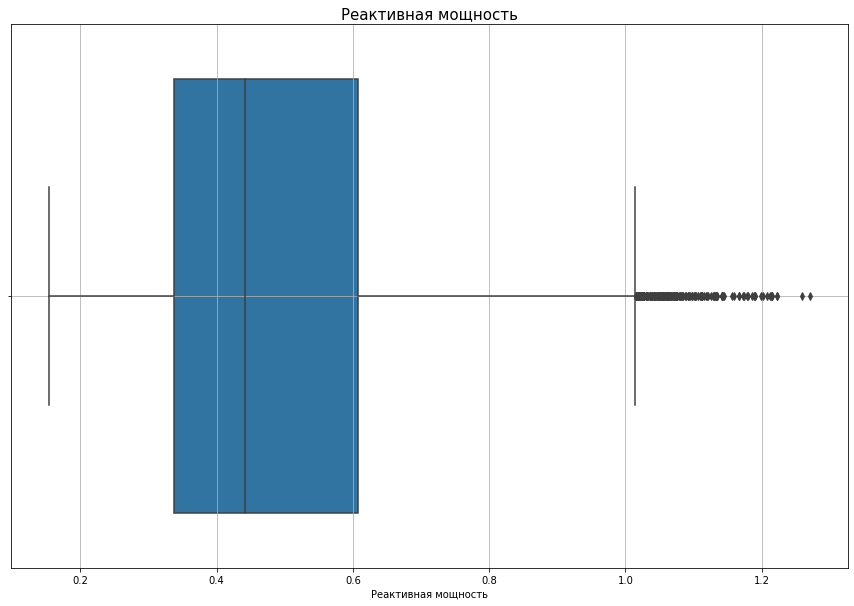

In [36]:
plt.figure(figsize=(15,10))
sns.boxplot(electrode['Реактивная мощность'])
plt.title('Реактивная мощность', fontsize=15)
plt.grid(True)
plt.show()

In [37]:
electrode[electrode['Реактивная мощность'] > 1.2].count()

key                     10
Начало нагрева дугой    10
Конец нагрева дугой     10
Активная мощность       10
Реактивная мощность     10
dtype: int64

Вывод: Были удалены явные выбросы в Реактивной мощности. Выбросы в газе решила не удалять, так как это могут быть особенности производства. 

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 3</b></u></p>ОК

### Замена пропусков

In [38]:
#syp_materials_ob - заменяю на 0


In [39]:
syp_materials_ob = syp_materials_ob.fillna(0)

In [40]:
syp_materials_ob

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [41]:
#provol_material_ob - заменяю на 0

In [42]:
provol_material_ob = provol_material_ob.fillna(0)

In [43]:
provol_material_ob

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Вывод: Заменила наны на нули, так как так будет лучше по условию бизнеса

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 3</b></u></p>согласен

### Перевод даты

In [44]:
#решила, ято данные с датой не понадобятся

### Расчет полной мощности

In [45]:
electrode['Полная мощность'] = np.sqrt(electrode['Активная мощность']**2 + electrode['Реактивная мощность']**2)


In [46]:
electrode['time_start'] = pd.to_datetime(electrode['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
electrode['time_finish'] = pd.to_datetime(electrode['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
electrode['time_delta'] = electrode['time_finish'] - electrode['time_start']
electrode['time_delta'] = electrode['time_delta'].dt.total_seconds()

electrode['tgfi'] = electrode['Реактивная мощность'] / electrode['Активная мощность']
electrode['act_power'] = electrode['Активная мощность']
electrode['act_energy'] = electrode['act_power'] * electrode['time_delta']
electrode

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,time_start,time_finish,time_delta,tgfi,act_power,act_energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,2019-05-03 11:02:14,2019-05-03 11:06:02,228.0,0.692338,0.305130,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,2019-05-03 11:07:28,2019-05-03 11:10:33,185.0,0.623566,0.765658,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,2019-05-03 11:11:44,2019-05-03 11:14:36,172.0,0.741772,0.580313,99.813836
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,2019-05-03 11:18:14,2019-05-03 11:24:19,365.0,0.732848,0.518496,189.251040
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,2019-05-03 11:26:09,2019-05-03 11:28:37,148.0,0.742321,0.867133,128.335684
...,...,...,...,...,...,...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,0.532085,2019-09-06 16:49:05,2019-09-06 16:51:42,157.0,0.681272,0.439735,69.038395
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,0.792429,2019-09-06 16:55:11,2019-09-06 16:58:11,180.0,0.708803,0.646498,116.369640
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,1.293389,2019-09-06 17:06:48,2019-09-06 17:09:52,184.0,0.739908,1.039726,191.309584
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,0.641792,2019-09-06 17:21:58,2019-09-06 17:22:55,57.0,0.681813,0.530267,30.225219


In [47]:
data_1 = electrode.groupby("key").agg(
    time_start=pd.NamedAgg(column="time_start", aggfunc="min"),
    time_finish=pd.NamedAgg(column="time_finish", aggfunc="max"),
    time_sum=pd.NamedAgg(column="time_delta", aggfunc="sum"),
    count_=pd.NamedAgg(column="time_delta", aggfunc="count"),
    tgfi_mean=pd.NamedAgg(column="tgfi", aggfunc="mean"),
    tgfi_min=pd.NamedAgg(column="tgfi", aggfunc="min"),
    tgfi_max=pd.NamedAgg(column="tgfi", aggfunc="max"),
    act_power_mean=pd.NamedAgg(column="act_power", aggfunc="mean"),
    act_power_max=pd.NamedAgg(column="act_power", aggfunc="max"),
    act_power_min=pd.NamedAgg(column="act_power", aggfunc="min"),
    energy_mean=pd.NamedAgg(column="act_energy", aggfunc="mean"),
    energy_sum=pd.NamedAgg(column="act_energy", aggfunc="sum"),
    energy_max=pd.NamedAgg(column="act_energy", aggfunc="max"),
    energy_min=pd.NamedAgg(column="act_energy", aggfunc="min")
)

data_1['time_all'] = data_1["time_finish"] - data_1["time_start"]
data_1['time_all'] = data_1['time_all'].dt.total_seconds()
data_1['tgfi_scope']=data_1['tgfi_max']-data_1['tgfi_min']
data_1['power_scope']=data_1['act_power_max']-data_1['act_power_min']
data_1['energy_scope']=data_1['energy_max']-data_1['energy_min']

display(data_1.head())
print(data_1.shape)

,time_start,time_finish,time_sum,count_,tgfi_mean,tgfi_min,tgfi_max,act_power_mean,act_power_max,act_power_min,energy_mean,energy_sum,energy_max,energy_min,time_all,tgfi_scope,power_scope,energy_scope
key,,,,,,,,,,,,,,,,,,
1,2019-05-03 11:02:14,2019-05-03 11:28:37,1098.0,5,0.706569,0.623566,0.742321,0.607346,0.867133,0.305130,125.723386,628.616930,189.25104,69.569640,1583.0,0.118755,0.562003,119.681400
2,2019-05-03 11:34:14,2019-05-03 11:53:18,811.0,4,0.684080,0.578161,0.785459,0.534852,0.786322,0.261665,98.820450,395.281800,165.12762,52.213988,1144.0,0.207298,0.524657,112.913632
3,2019-05-03 12:06:54,2019-05-03 12:32:19,655.0,5,0.725034,0.646352,0.874691,0.812728,1.222963,0.421693,116.354925,581.774624,308.46984,27.410045,1525.0,0.228339,0.801270,281.059795
4,2019-05-03 12:39:37,2019-05-03 12:57:50,741.0,4,0.765897,0.725883,0.802666,0.676622,0.887855,0.310693,135.927569,543.710274,240.46861,30.758607,1093.0,0.076783,0.577162,209.710003
5,2019-05-03 13:11:13,2019-05-03 13:33:55,869.0,4,0.758599,0.668656,0.859932,0.563238,0.892957,0.324563,103.045120,412.180480,191.57230,63.399947,1362.0,0.191276,0.568394,128.172353


(3214, 18)


In [48]:
electrode

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,time_start,time_finish,time_delta,tgfi,act_power,act_energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,2019-05-03 11:02:14,2019-05-03 11:06:02,228.0,0.692338,0.305130,69.569640
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,2019-05-03 11:07:28,2019-05-03 11:10:33,185.0,0.623566,0.765658,141.646730
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,2019-05-03 11:11:44,2019-05-03 11:14:36,172.0,0.741772,0.580313,99.813836
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,2019-05-03 11:18:14,2019-05-03 11:24:19,365.0,0.732848,0.518496,189.251040
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,2019-05-03 11:26:09,2019-05-03 11:28:37,148.0,0.742321,0.867133,128.335684
...,...,...,...,...,...,...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,0.532085,2019-09-06 16:49:05,2019-09-06 16:51:42,157.0,0.681272,0.439735,69.038395
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,0.792429,2019-09-06 16:55:11,2019-09-06 16:58:11,180.0,0.708803,0.646498,116.369640
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,1.293389,2019-09-06 17:06:48,2019-09-06 17:09:52,184.0,0.739908,1.039726,191.309584
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,0.641792,2019-09-06 17:21:58,2019-09-06 17:22:55,57.0,0.681813,0.530267,30.225219


Вывод: рассчитала полную мощность для обучения

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 3</b></u></p>таааак, тут понятно!

### Обьединение данных

In [49]:
#izmer_temp['Температура 1'].count()

In [50]:
izmer_temp['Температура'].count()

13926

In [51]:
electrode['key'].count()

14875

In [52]:
electrode = electrode[['key', 'Полная мощность']]


In [53]:
#izmer_temp
izmer_temp = izmer_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
izmer_temp.columns = izmer_temp.columns.droplevel()
izmer_temp.columns = ['key','Замер 1', 'Замер 2', 'Температура 1', 'Температура 2']
izmer_temp = izmer_temp[['key', 'Температура 1', 'Температура 2']]

In [54]:
electrode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              14875 non-null  int64  
 1   Полная мощность  14875 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 864.7 KB


In [55]:
electrode = electrode.groupby(by = 'key').agg(['first', 'last']).reset_index()
electrode.columns = electrode.columns.droplevel()
electrode.columns = ['key','Полная 1', 'Полная 2' ]
electrode = electrode[['key', 'Полная 1', 'Полная 2']]

In [56]:
data = (izmer_temp.merge(gas, how='inner', on='key')
         .merge(electrode, how='inner', on='key')
         .merge(syp_materials_ob, how='inner', on='key')
         .merge(provol_material_ob, how='inner', on='key')
         .merge(data_1, how='inner', on='key')
       )

In [57]:
data['Температура 2'].unique()

array([1613., 1602., 1599., 1625., 1596., 1598., 1592., 1593., 1597.,
       1591., 1619., 1606., 1607., 1595., 1603., 1618., 1585., 1600.,
       1601., 1604., 1609., 1617., 1621., 1612., 1588., 1589., 1574.,
       1573., 1576., 1581., 1580., 1594., 1590., 1586., 1583., 1578.,
       1587., 1582., 1647., 1547., 1620., 1610., 1579., 1572., 1605.,
       1616., 1584., 1624., 1570., 1577., 1575., 1622., 1614., 1608.,
       1615., 1611., 1623., 1642., 1631., 1556., 1564., 1568., 1629.,
       1628., 1653., 1569., 1633., 1554., 1550., 1626., 1545., 1543.,
       1541., 1551., 1566.])

In [58]:
data = data.rename(columns={'Температура 2': 'temp',
                            'Температура 1': 'temp_1',
                            'Газ 1': 'gas',
                            'Полная 1': 'full',
                            'Полная 2': 'full_2',
                           })

In [59]:
data[data['temp'] <= 1450]

,key,temp_1,temp,gas,full,full_2,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,act_power_max,act_power_min,energy_mean,energy_sum,energy_max,energy_min,time_all,tgfi_scope,power_scope,energy_scope


In [60]:

data = data.drop(['key'], axis = 1)

In [61]:
data

,temp_1,temp,gas,full,full_2,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,act_power_max,act_power_min,energy_mean,energy_sum,energy_max,energy_min,time_all,tgfi_scope,power_scope,energy_scope
0,1571.0,1613.0,29.749986,0.371123,1.079934,0.0,0.0,0.0,43.0,0.0,...,0.867133,0.305130,125.723386,628.616930,189.251040,69.569640,1583.0,0.118755,0.562003,119.681400
1,1581.0,1602.0,12.555561,0.440239,0.955315,0.0,0.0,0.0,73.0,0.0,...,0.786322,0.261665,98.820450,395.281800,165.127620,52.213988,1144.0,0.207298,0.524657,112.913632
2,1596.0,1599.0,28.554793,1.373863,0.502111,0.0,0.0,0.0,34.0,0.0,...,1.222963,0.421693,116.354925,581.774624,308.469840,27.410045,1525.0,0.228339,0.801270,281.059795
3,1601.0,1625.0,18.841219,0.824445,1.084803,0.0,0.0,0.0,81.0,0.0,...,0.887855,0.310693,135.927569,543.710274,240.468610,30.758607,1093.0,0.076783,0.577162,209.710003
4,1576.0,1602.0,5.413692,0.428064,1.110873,0.0,0.0,0.0,78.0,0.0,...,0.892957,0.324563,103.045120,412.180480,191.572300,63.399947,1362.0,0.191276,0.568394,128.172353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1570.0,1591.0,7.125735,0.561225,1.086811,0.0,0.0,21.0,0.0,0.0,...,1.055713,0.430979,142.884829,571.539318,247.036842,85.344930,1208.0,0.211261,0.624734,161.691912
2325,1554.0,1591.0,9.412616,0.403804,1.547188,0.0,0.0,0.0,63.0,0.0,...,1.309449,0.313432,112.537078,675.222467,298.554372,38.964393,1569.0,0.135644,0.996017,259.589979
2326,1571.0,1589.0,6.271699,1.531931,1.560949,0.0,0.0,0.0,85.0,0.0,...,1.270521,1.066340,226.775558,680.326674,261.727326,197.866968,824.0,0.070259,0.204181,63.860358
2327,1591.0,1594.0,14.953657,0.512900,0.625538,0.0,0.0,90.0,0.0,0.0,...,0.999939,0.419017,94.983759,474.918795,161.735351,20.860226,1358.0,0.121358,0.580922,140.875125


<div class="alert alert-danger" style="border-color: darkred; border-radius: 5px">
    <p><u><b>❌ КОММЕНТАРИЙ ТИМЛИДА 3</b></u></p>
    <p>В целом - ОК. НО есть важные моменты:<br>
1) У нас объект моделирования - ковш. Поэтому в итоговоом датасете должно быть не более строк, чем в самих ковшей. А у нас тут разраслось)). Нужно к темп мержить остальные таблицы. А мощность сначала агрегировать по партии. Т.у. суммарную полную мощность получить<br>
    
2) у нас ковши наблюдаются, в которых нет целвой, но есть первая температура. А объект моделирования у нас - ковш. И если нет целевой у объекта - надо удалять весь ковш. Сейчас они всё ещё в деле))). Наприм ковш номер 3000 - целевой нет. Значить надо удалить. А он всё равно в таблице остался. Посмотри, пожалуйста. В итоге у нас должно быть не больь 2300 строк +-)<br>
        
3) Наша целевая - последняя температура по партии!!! Её, вроде ещё нет в данных...<br>        
<br>
    
Далее, пока смотерть не буду. Надо сначала получить ту самую таблицу)<br>

</p>
</div>

Вывод: обьединяю в один датасет по ключу. В Температуре много пропусков, удалю эти строки дальше, так как они не валидны для обучения.

### Корреляция 

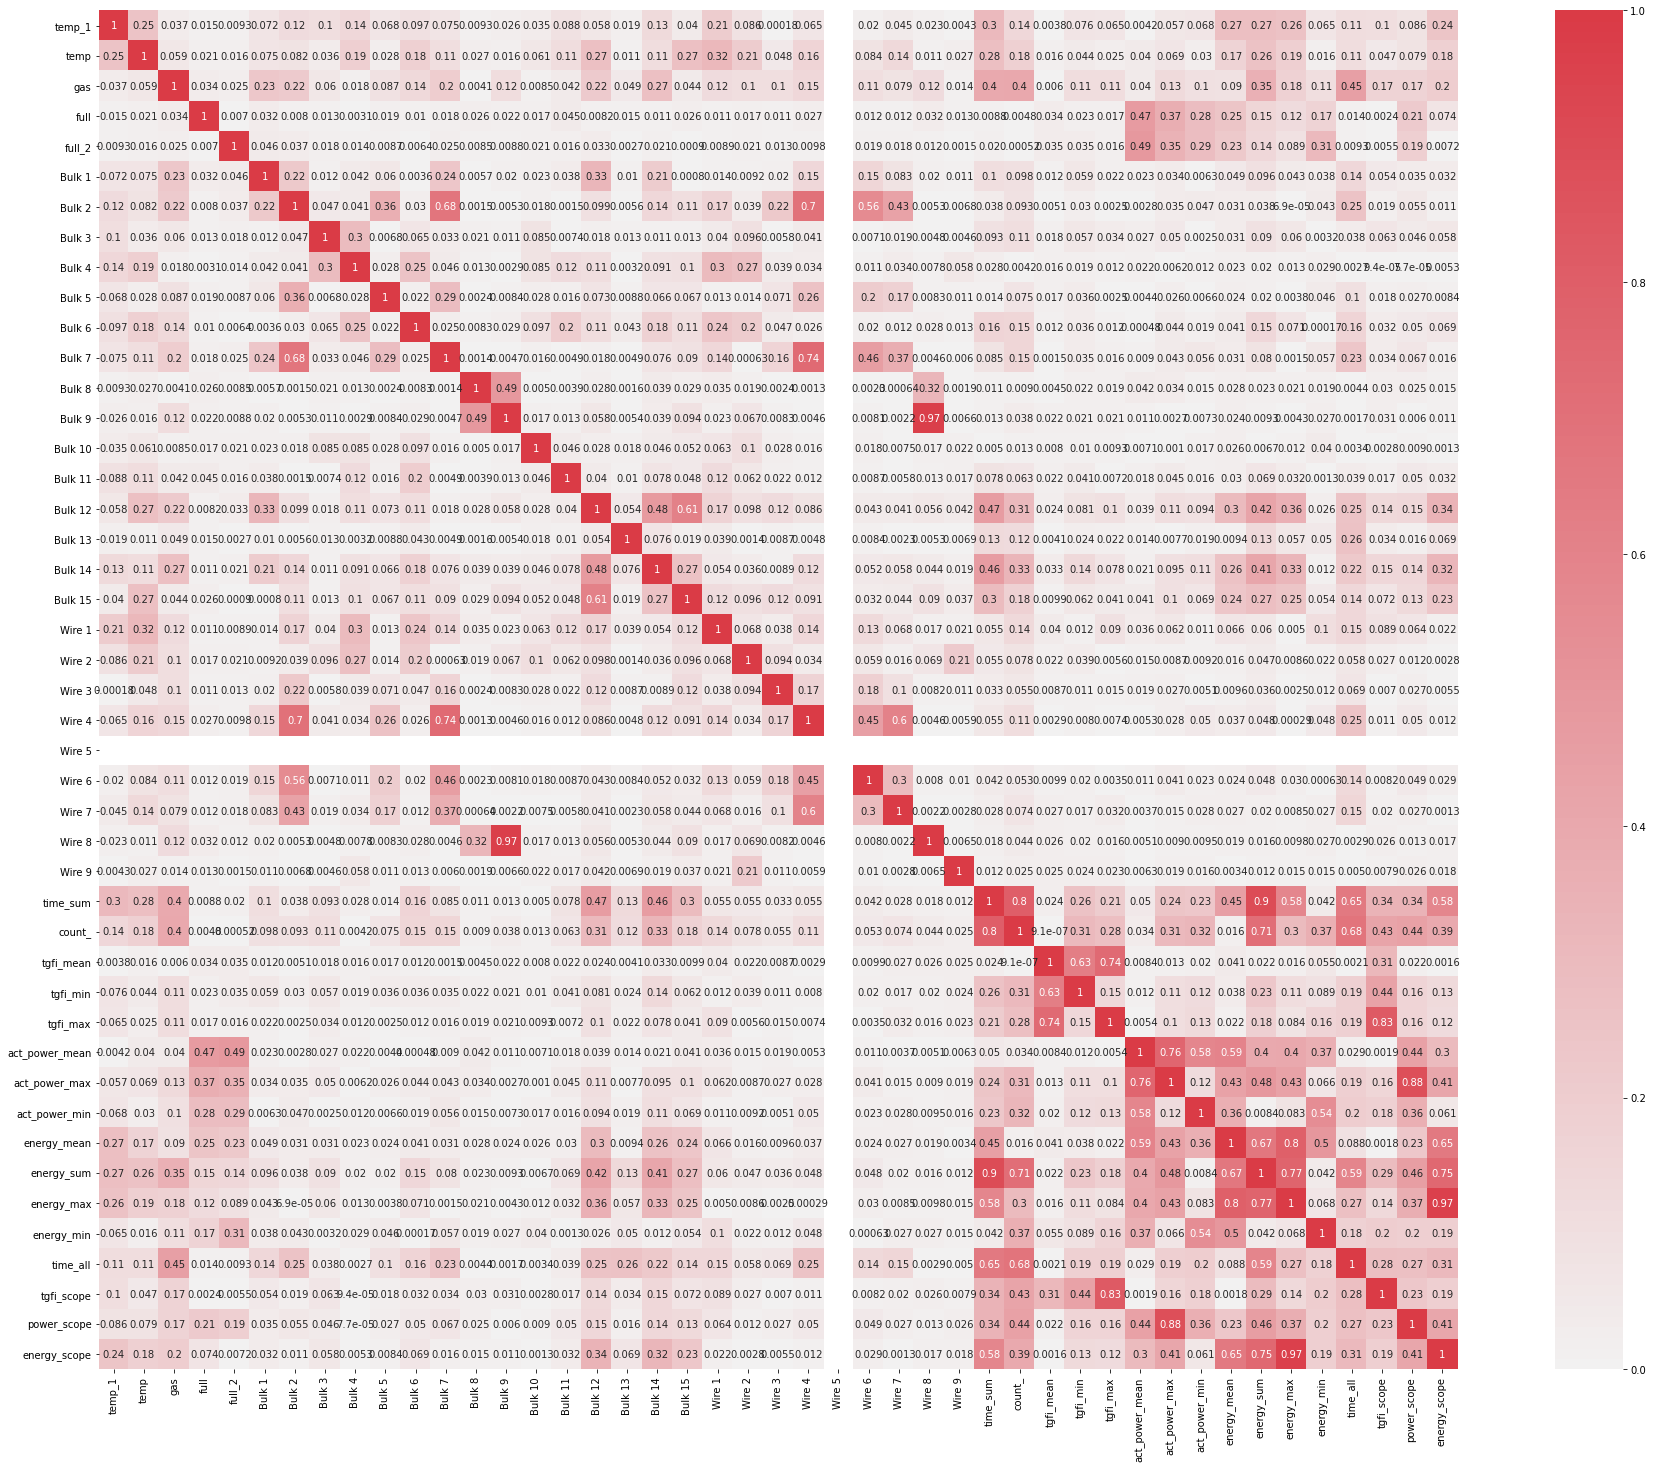

In [62]:
corr = abs(data.corr())

f, ax = plt.subplots(figsize=(35,25))

font = {'size': 10}
plt.rc('font', **font)


cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(
    corr,          
    cmap=cmap,     
    annot=True,    
    vmax=1,       
    vmin=0,      
    center=0,      
    square=True,   
    linewidths=0, 
    xticklabels=True, yticklabels=True
)

In [63]:
data = data.drop(['Wire 8', 'Bulk 9','energy_sum'], axis = 1)

In [64]:
data = data.drop(['energy_max','energy_scope'], axis = 1)

In [65]:
data = data.drop(['time_start','time_finish'], axis = 1)

In [66]:
#data = data.drop(['count_'], axis = 1)

In [67]:

data = data.drop(['act_power_max','tgfi_max'], axis = 1)

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp_1          2329 non-null   float64
 1   temp            2329 non-null   float64
 2   gas             2329 non-null   float64
 3   full            2329 non-null   float64
 4   full_2          2329 non-null   float64
 5   Bulk 1          2329 non-null   float64
 6   Bulk 2          2329 non-null   float64
 7   Bulk 3          2329 non-null   float64
 8   Bulk 4          2329 non-null   float64
 9   Bulk 5          2329 non-null   float64
 10  Bulk 6          2329 non-null   float64
 11  Bulk 7          2329 non-null   float64
 12  Bulk 8          2329 non-null   float64
 13  Bulk 10         2329 non-null   float64
 14  Bulk 11         2329 non-null   float64
 15  Bulk 12         2329 non-null   float64
 16  Bulk 13         2329 non-null   float64
 17  Bulk 14         2329 non-null   f

In [75]:
data

,temp_1,temp,gas,full,full_2,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,count_,tgfi_mean,tgfi_min,act_power_mean,act_power_min,energy_mean,energy_min,time_all,tgfi_scope,power_scope
0,1571.0,1613.0,29.749986,0.371123,1.079934,0.0,0.0,0.0,43.0,0.0,...,5,0.706569,0.623566,0.607346,0.305130,125.723386,69.569640,1583.0,0.118755,0.562003
1,1581.0,1602.0,12.555561,0.440239,0.955315,0.0,0.0,0.0,73.0,0.0,...,4,0.684080,0.578161,0.534852,0.261665,98.820450,52.213988,1144.0,0.207298,0.524657
2,1596.0,1599.0,28.554793,1.373863,0.502111,0.0,0.0,0.0,34.0,0.0,...,5,0.725034,0.646352,0.812728,0.421693,116.354925,27.410045,1525.0,0.228339,0.801270
3,1601.0,1625.0,18.841219,0.824445,1.084803,0.0,0.0,0.0,81.0,0.0,...,4,0.765897,0.725883,0.676622,0.310693,135.927569,30.758607,1093.0,0.076783,0.577162
4,1576.0,1602.0,5.413692,0.428064,1.110873,0.0,0.0,0.0,78.0,0.0,...,4,0.758599,0.668656,0.563238,0.324563,103.045120,63.399947,1362.0,0.191276,0.568394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1570.0,1591.0,7.125735,0.561225,1.086811,0.0,0.0,21.0,0.0,0.0,...,4,0.717028,0.622856,0.792033,0.430979,142.884829,85.344930,1208.0,0.211261,0.624734
2325,1554.0,1591.0,9.412616,0.403804,1.547188,0.0,0.0,0.0,63.0,0.0,...,6,0.699003,0.629345,0.695820,0.313432,112.537078,38.964393,1569.0,0.135644,0.996017
2326,1571.0,1589.0,6.271699,1.531931,1.560949,0.0,0.0,0.0,85.0,0.0,...,3,0.678181,0.643487,1.201746,1.066340,226.775558,197.866968,824.0,0.070259,0.204181
2327,1591.0,1594.0,14.953657,0.512900,0.625538,0.0,0.0,90.0,0.0,0.0,...,5,0.699959,0.646701,0.640462,0.419017,94.983759,20.860226,1358.0,0.121358,0.580922


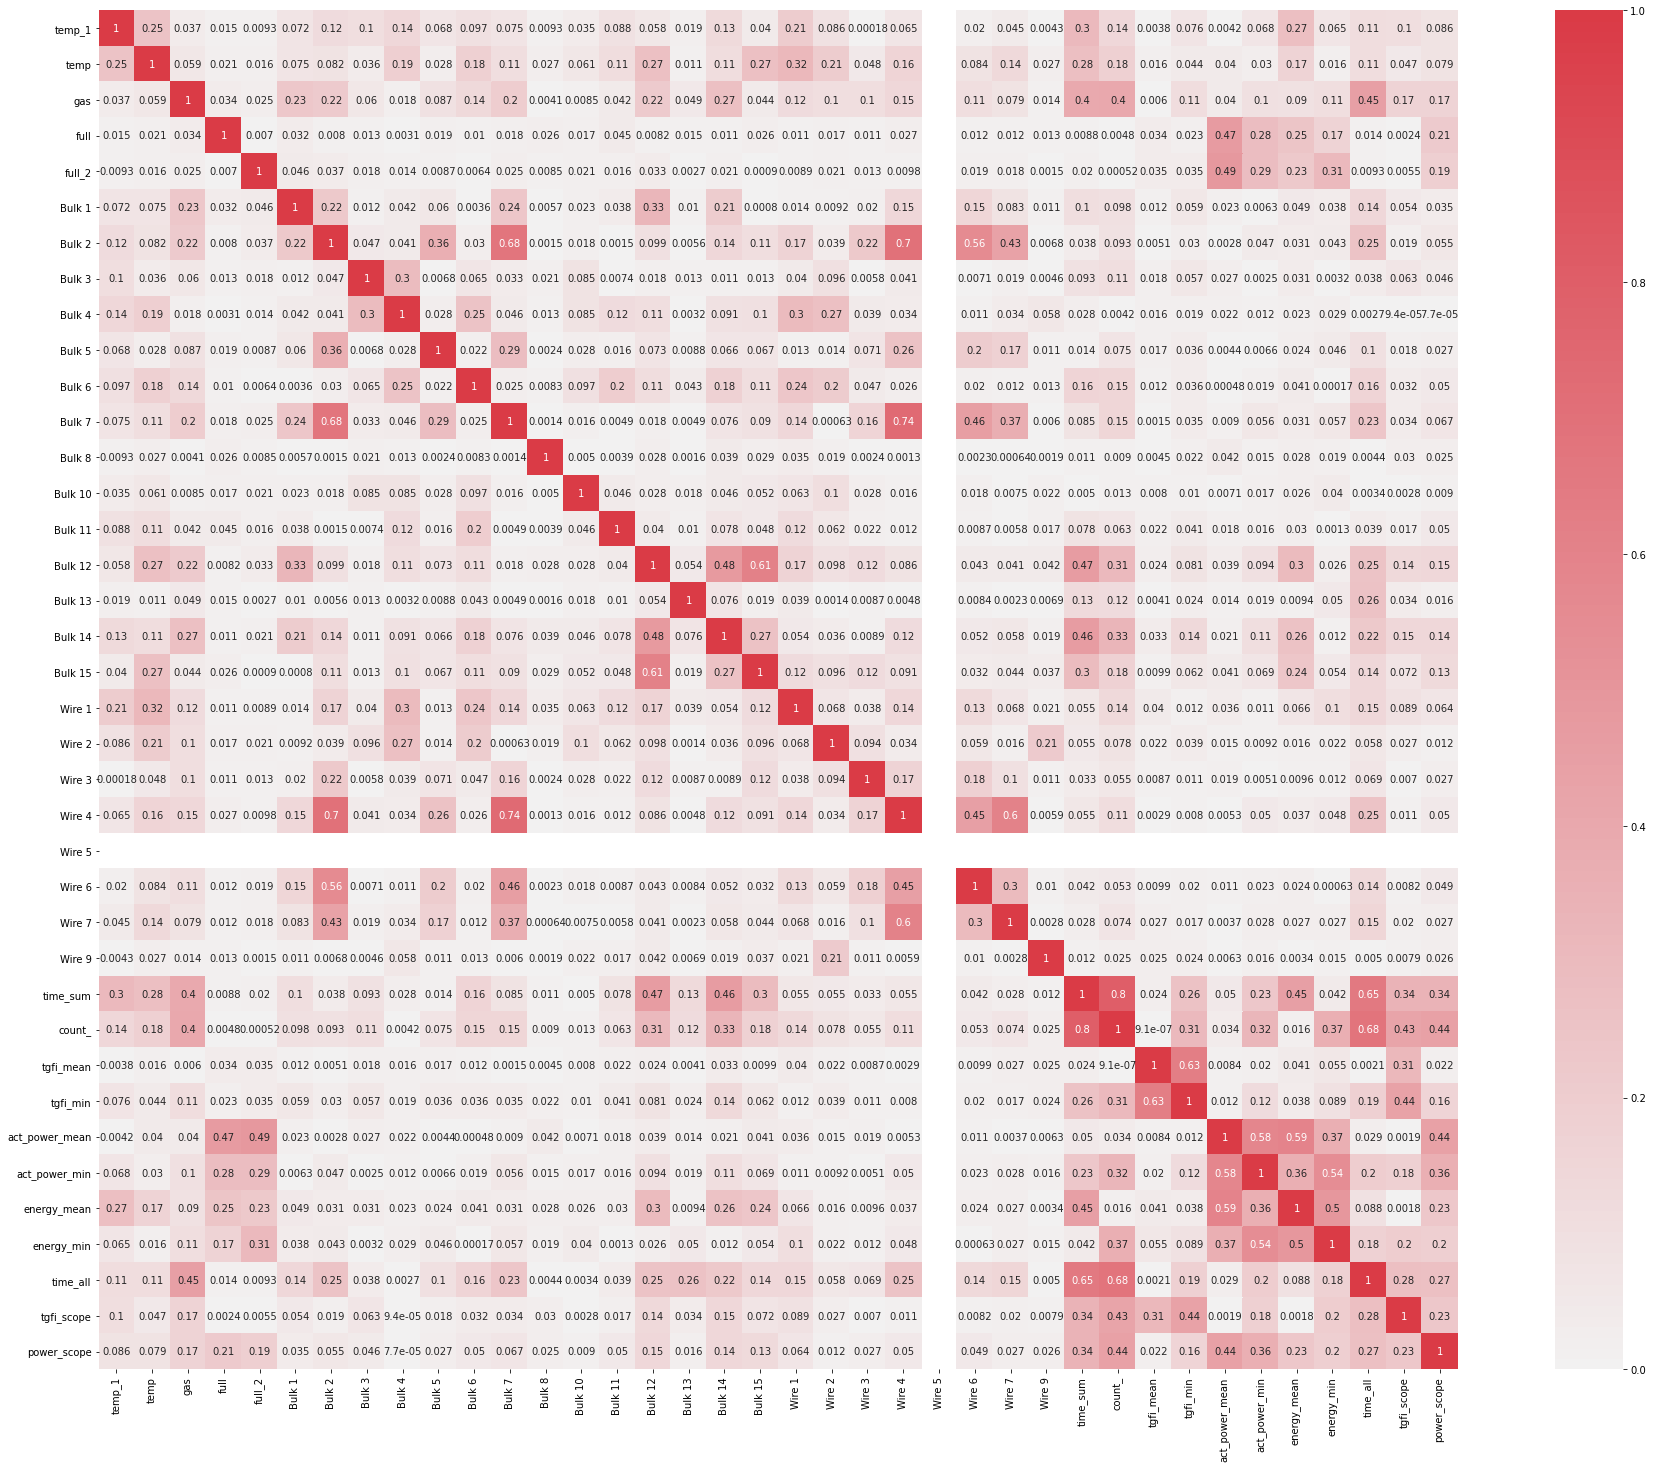

In [74]:
corr = abs(data.corr())

f, ax = plt.subplots(figsize=(35,25))

font = {'size': 10}
plt.rc('font', **font)


cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(
    corr,          
    cmap=cmap,     
    annot=True,    
    vmax=1,       
    vmin=0,      
    center=0,      
    square=True,   
    linewidths=0, 
    xticklabels=True, yticklabels=True
)

Вывод:  Видны сильные зависимости и слабые. 

## Вывод по предобработке данных

Были удалены выбросы

Заменены Nan значения на нули

Удалены лишние признаки

Проведена проверка корреляции

## Построение модели машинного обучения 

<div class="alert alert-danger" style="border-color: darkred; border-radius: 5px">
    <p><u><b>❌ КОММЕНТАРИЙ ТИМЛИДА 3</b></u></p>
Краем глаза глягул)) кей - просто как фамилия ковша. Его не стоит в факторах оставлять) Удаляем. Время (день, число, минут) - также не используем как фактор! </p>
</div>

### выборка

In [69]:
features = data.drop(['temp', 'Wire 5'],axis=1) 
target = data['temp']
features_train, features_test, target_train, target_test= train_test_split(
features, target, test_size=0.25,shuffle=True, random_state=22052023)

In [70]:
features_train.shape, features_test.shape

((1746, 37), (583, 37))

In [71]:
numeric = data.columns.tolist()
numeric = [i for i in numeric if i not in ("temp")]
scaler = MinMaxScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/tmp/ipykernel_203/1669368568.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_203/1669368568.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

### Обучение модели

#### Линейная регрессия

In [72]:
%%time 
model_LR = LinearRegression()
scores = cross_val_score(model_LR, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')
print('MAE:',np.abs(np.mean(scores)))

MAE: 6.331918588902974
CPU times: user 425 ms, sys: 535 ms, total: 960 ms
Wall time: 874 ms


#### DecisionTreeRegressor

In [73]:
%%time


model=DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')
print('MAE:',np.mean(np.abs(scores)))



MAE: 7.1740946744304335
CPU times: user 70.7 ms, sys: 3.47 ms, total: 74.1 ms
Wall time: 72.4 ms


#### RandomForestRegressor


In [80]:
%%time

regressor = RandomForestRegressor() 
hyperparams = [{'criterion':['mse'],
                'n_estimators':[x for x in range(50, 701, 50)], 
                'random_state':[22052023], 
                #'max_depth': [depth for depth in range(1, 30, 2)]
               }]

print('# Tuning hyper-parameters for mean_absolute_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_absolute_error', cv=5)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
best_params_RFR = clf.best_params_
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()

cv_MAE_RFR = (max(means)*-1)

# Tuning hyper-parameters for mean_absolute_error

Best parameters set found on development set:

{'criterion': 'mse', 'n_estimators': 500, 'random_state': 22052023}

Grid scores on development set:

6.151990 for {'criterion': 'mse', 'n_estimators': 50, 'random_state': 22052023}
6.156250 for {'criterion': 'mse', 'n_estimators': 100, 'random_state': 22052023}
6.153000 for {'criterion': 'mse', 'n_estimators': 150, 'random_state': 22052023}
6.149962 for {'criterion': 'mse', 'n_estimators': 200, 'random_state': 22052023}
6.132948 for {'criterion': 'mse', 'n_estimators': 250, 'random_state': 22052023}
6.129771 for {'criterion': 'mse', 'n_estimators': 300, 'random_state': 22052023}
6.127004 for {'criterion': 'mse', 'n_estimators': 350, 'random_state': 22052023}
6.130317 for {'criterion': 'mse', 'n_estimators': 400, 'random_state': 22052023}
6.129736 for {'criterion': 'mse', 'n_estimators': 450, 'random_state': 22052023}
6.126325 for {'criterion': 'mse', 'n_estimators': 500, 'random_state': 2

#### CatBoostRegressor

In [81]:
%%time

regressor = CatBoostRegressor(verbose=False, random_state=22052023)
print('# Train for mean_absolute_error')
print()
cv_MAE_CBR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Mean MAE from CV of CatBoostRegressor =', cv_MAE_CBR)
print()
print("Best parameters set found on development set:")
print()
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=22052023).fit(features_train, 
                                        target_train).get_all_params()
best_params_CBR

# Train for mean_absolute_error

Mean MAE from CV of CatBoostRegressor = 5.901389285508275

Best parameters set found on development set:

CPU times: user 34 s, sys: 752 ms, total: 34.7 s
Wall time: 39.6 s


{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 22052023,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04471199959516525,
 'score_function': 'Cosine',
 'tas

#### LGBMRegressor

In [ ]:
%%time 

hyper_param_list = []

def calc_mae(learning_rate):
    
    def mae(y_true, y_pred):
        return mean_absolute_error(y_true,y_pred)
      
    learning_rate = round(learning_rate,2)
    mae = make_scorer(mae, greater_is_better=False)
    sgb = LGBMRegressor(metric='auc',random_state = 22052023,
                        n_jobs = -1,learning_rate = round(learning_rate,2), silent = True)
    _mae = np.mean(np.abs(cross_val_score(sgb,features_train,target_train,scoring=mae,error_score='raise')))
    return learning_rate,_mae
    
for learning_rate in np.linspace(0.05, 1.0, num=20):
    learning_rate,_mae = calc_mae(learning_rate)
    hyper_param_list.append([learning_rate,_mae])    
    
hyper_param_list = pd.DataFrame(hyper_param_list,columns=['learning_rate','MAE'])
display(hyper_param_list.sort_values(by='MAE')[:10])

### Test

In [82]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_CBR)
model.fit(features_train, target_train)
predict = model.predict(features_test)
test_MAE_CBR = mean_absolute_error(predict, target_test)
print('MAE on test of CatBoostRegressor =', test_MAE_CBR)

MAE on test of CatBoostRegressor = 6.409992088171827
CPU times: user 5.84 s, sys: 96.6 ms, total: 5.94 s
Wall time: 6.67 s


### Анализ важности факторов

In [83]:
model.feature_importances_


array([1.80969341e+01, 3.30845684e+00, 2.64587645e+00, 1.99191254e+00,
       1.08668324e+00, 2.75541831e-02, 1.36795126e+00, 1.12197226e+00,
       2.91397409e-02, 4.98665215e+00, 2.45970744e-01, 2.64314458e-04,
       3.58009828e-01, 3.34997776e-01, 3.30032310e+00, 1.96350418e-02,
       3.33262201e+00, 3.23758870e+00, 5.43054588e+00, 3.26492817e+00,
       6.06455884e-02, 3.56890343e-03, 0.00000000e+00, 1.41187124e-01,
       0.00000000e+00, 5.53077910e-04, 1.92137807e+01, 1.23797352e+00,
       2.16633729e+00, 2.54643287e+00, 1.38911254e+00, 2.14596997e+00,
       3.08324068e+00, 2.72329334e+00, 6.86362049e+00, 2.76816069e+00,
       1.46810491e+00])

Text(0.5, 0, 'catboost')

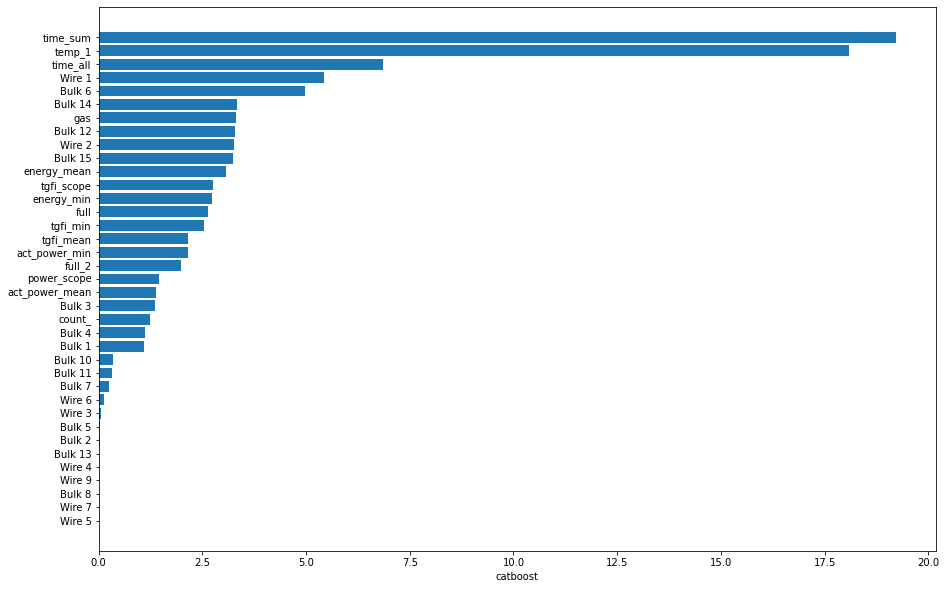

In [84]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = model.feature_importances_.argsort()
plt.barh(features_test.columns.values[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("catboost")

## Общий вывод

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстояло построить модель, которая предскажет температуру стали.

Нами был проведен анализ данных,предобработка и обучение моделей. При обучении моделей - наилучший результат оказался у CatBoostRegressor, который на тестовой выборке показал mae = 6.4. Таким образом, можно  рекомендовать эту модель для использования. Также стоило провести анализ важности факторов, который показал что значимыми являются - количество времени и начальная температура. 

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 3</b></u></p>
ОК, Эллина, с метрикой всё верно теперь. Можно сказать, что пройден весь алгоритм моделирования от анализа исходной инфо до анализа важности факторов.<br> По факторам могу вот что сказать. Есть такое правило внегласное: при одинаковой метрике выбираем ту модель, у которой меньшее количество факторов. Сейчас в этой модели много факторов. А достичь метрику можно и за меньшее количество. Т.е. модель не очень удобня будет на практике. Почему так? ведь каждый фактор в модели требуется ещё будет прогнозировать для нового ковша. И сколько нам надо будет дополнительных моделей построить?) А у каждой из них ещё будет своя ошибка. Итого общая ошибка будет огого)) Я приму проект. НО обязательно учти этот момент в работе!!!!<br>
 
 
Всегда стараюсь на этом проекте сказать всем вот ещё что: цель заказчика - экономия энергоресурсов.<br>
И в этом проекте искали как раз способ точно предсказывать температуру. И круто использовали для этого весь арсенал<br>
А если рассудать с позиции такой: а что нужно сделать, чтобы снизить энергопотребление?<br>
Судя по модели, самым важным фактором является первая температура. Это значит, что управляя ею, мы сможем управлять энергозатратами. Вывод понятен. Теперь надо разработать мероприятия для этого решения. И тут вопрос возникает скм собой: а это так точно? мы можем управлять первой температурой? В общем, наша модель - только начало работы над энергоэффективностью.<br>
    
Так же есть ещё одна идея, которую хотел предложить тебе на обсуждение.<br>
Возможно, покажется интересным<br><br> 

Дело касается принципиально иного подхода к поиску решения для снижения энергопотребления на производстве<br>
Смотри, Создание данной модели (таково было задание) двигалось по пути "угадывания" температуры<br>
Но мы же знаем жизнь)) лёгкие колебания температур (как и нашего настроения, нашего веса.....)<br>
есть всегда. Более того - будут вегда! И нам что, стараться угадывать их?<br>
Не угонимся, "пупок" развяжется))))) <br>
Предложу для подобных проектов подумать вот в какую сторону<br>
    
Итак, разброс в измерениях - есть, был и будет!! (т.к. этому благоприятствует разнообразие факторов самого проиозводства)<br>
    Тогда задачу можно поставить так: <u>надо уменьшить разброс в измерениях</u>. В данном случае в температуре.<br>
Один из подходов такой: Наверняка есть границы, в пределах которых колебания температур - дело нормальное.<br>
А что, если фикировать случаи, когда температура выходит за эти границы?<br>
Скажем, как "1". И тогда для таких моментов времени собирать инфо по производству: <br>
а что был за материал (химия материала), что был за газ (химический состав газа), какая бригада работала, <br>
что там было с электродами, ограничения только в фантазиях ну и в знаниях самого производства..... <br>
И вот тут можем реально находить причины (через корреляции, проверки гипотез, разные модельки...), фиксировать эти причины. <br>
Ну и разрабатывать энергосберегательные мероприятия.<br><br>
 
Это было отступление)<br>    
Тогда впереди только отчёт. Что для него важно - оставлял в презентации. <br>
БУДУ ЖДАТЬ! <

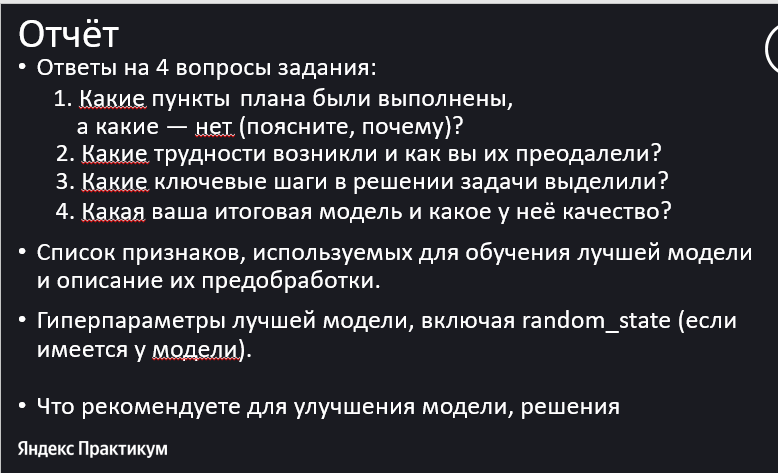

# Отчет

**Было выполнено:**
    
- Составлен план работы

- Изучены данные

- Заказчиком (веб) обьяснен технический процесс работы. Выяснена природа пропуска в данных. 

- Далее были предобработаны данные, приведены  в порядок, поработала с пропусками, были удалены выбросы, проведен расчет корреляции

- Посчитана полная мощность, тангенс фи и т.п. для улучшения модели

- По итогу преобработанных данных начала формировать финальный датасет

- По корреляционной таблице выявила факторы для удаления из итогового датасета, которые бы подпопортили процесс обучения

- Создана обучающая и тестовая выборка для моделей с размером тестовой выборки = 0,25

- Обучены модели: LinearRegression,DecisionTreeRegressor, RandomForest, CatBoostRegressor, LGBMRegressor (два последних с поиском лучших гиперпараметров)

- Проведено тестирование модели CatBoostRegressor на тестовых данных, где итоговое mae = 6.4

- Был проведен анализ важности факторов (по совету тимлида)

**Вывод**

Возникли трудности с удалением ненужных признаков и с добавлением нужных. Без помощи тимлида и одногруппников не разобралась бы, так как хоть технический процесс и стал понятнее после веба, но оставались вопросы в том, что нам поможет достичь нужной метрики, а что нет. Пришлось хорошо посидеть:)

При обучении моделей использовались уже "проверенные" параметры, коды, само собой, модели с подбором гиперпараметров. Были лишь некоторые видоизменения для улучшения метрики. 

Для улучшения модели рекомендовала бы еще поработать с итоговым датасетом и, возможно, использовать оптуну и т.п. 

П.С. Очень интересно было прочитать лирическое отступление, но не совсем поняла, к чему идет дело во втором случае:)Просить больше данных у производства? 

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 4</b></u></p>
И вновь привет, Эллина!<br>С отчётом - лаконично, но главное понятно.<br>
Во втором случае (в лирическом отступлении) можно пао разному. Можно модель классификации, можно использовать  "Статистичекий контроль качества (SPC)" (ниже написал). Тут идея такая: одну задача всегда можно решить несколькими способами. Главное - поставить цель)<br><br>
    
Поздравляю с получением диплома о новой специальности!!!!<br>       
Добавлю вот что ещё: изучение бизнес-процессов заказчика - очень важный этап, который может вызывать сложности. Но без этого в нашей работа не обойтись. Можно сказать - вскрывать особенности процессов заказчика - часть нашей работы. Ведь замоделировать можно только то, что понимаешь). Также, хотел бы отметить твою графическую работу. Она  подкрепляла аналитику. На защите заказчику - хорошая графика - может прибавить дополнительной лояльности. Поэтому, стоит её улублять и дальше. <br><br>
    
Далее скажу, что стараюсь говорить всем на финале.<br>
Пройден большой путь. Со своими коcогорами и равнинами, медианами и дисперсиями)<br>
Умение аналитически мыслить, писать красивый код, эффективно автоматизировать расчёты, видеть задачи бизнеса через призму моделирования - вот то основное, что  останется у тебя важного после нашей школы. А дальше - только взращивать посеянные зёрна и укреплять свои скилы.<br><br>
Если говорить о развитии дополнительных компетенций, рекомендовал бы ещё глянуть такие области знаний:<br>
1) Организация проектов по проведению моделирования (например Методология CRISP-DM (Cross-Industry Standard Process)<br>
2) Умения системно подходить к решению аналитической задачи. (например методология ТРИЗ, системный анализ)<br>
3) Если в промышленности будут проекты, то рекоммендовал бы освоить  "Статистичекий контроль качества (SPC)"<br>
4) Ещё важный навык: перевод результататов моделирования на язык бизнеса. Т.е. понимание, как целевые показатели моделей влияют на финансовую выгоду заказчика.<br>

Каждого из нас (и меня в том числе) можно оценивать с нескольких сторон, как специалиста.<br>
1) Умение анализировать, "вгрызание" в данные, в задачу.<br>
2) Знание мат.части: методы, подходы к решению - всё, что по программе заложено<br>
3) Кодовая часть: умение писать эффективный код.<br>
4) Работа с графикой. (умение хорошо ыизуализировать)<br>
И при рабочей деятельности (устраивание на работу/ улучшение карьеры) на важно понимать свои слабые/сильные стороны по этим направлениям. И опираться на них при ведении переговоров и выстраивании дальнейшего совершенствования.<br><br>
    
Спасибо за этот труд и за совместную работу на других проектах)<br>
Искренне желаю покорить ещё не один аналитический Эверест)<br>  

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
С планом - ооооооо-очень лаконично. Сюда же можно включить проверку на мультиколлинеарность ДО моделирования и анализ важности факторов у модели-победителя). А если выходить на встречу с заказчиком, то подобный план лучше оформлять в виде списка.<br>